# Simple Temporal Networks
Welcome to Lesson 1 of our series on Cognitive Robotics! These lectures will loosely follow those you might see on the [16.412 OpenCourseWare](https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-412j-cognitive-robotics-spring-2016/). They are a great way to begin learning how to apply autonomy to real-world systems in the form of cognitive robots.

In this lesson, we'll walk through the basics of how to talk about and design systems that can flexibly respond to disturbances in their execution.

## Basic Setup

As you go through this notebook, make sure you run the Python cells to see all the diagrams.

Before we get going, let's setup the notebook.

In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
from render import *
%matplotlib inline

## Motivations

Temporal networks form the backbone of planning algorithms. They exist to solve the problem of managing relationships between events. The ideas behind temporal networks are very simple. Have you ever planned the details of how you're doing to cook a meal? How about a travel itinerary for a vacation? If so, you're already familiar with temporal networks.

In this lesson, we'll help you take your intuition about writing down plans and turn it into formal temporal networks. You'll also see the benefit in formal temporal networks when we take on the role of a robot and use temporal networks to decide what to do and when.

Flexible time enables more robustness from our cognitive robots. Rather than tell a robot to take action A at minute 3, followed by action B at minute 5, we can instead tell the robot that actions A and B must be separated by 2-4 minutes. The cognitive robot is then able to use these constraints to generate a schedule _autonomously_. This allows us to have much more flexibility in the execution of our plans. 

Imagine that action B depends on action A. If action A doesn't start until minute 4, but action B still needs to happen 2 minutes after action A, then we should not schedule B until at least minute 6. Our original schedule of A at mniute 3 and B at 5 does not satisfy the constraint. This is getting complicated! Let's talk about some ways we can represent these complex time dependencies in an easy-to-digest manner.

## Events and Constraints

The basic unit of a temporal network is an event. An event represents a specific point in time. If you're cooking pasta, an event might represent the instant of turning the burner on to boil a pot of water. There is a code snippet below that creates and draws an event. We usually draw an event as a circle with a label.

**Make sure you Run the cell with Python below to see the event**

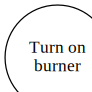

In [2]:
stn = nx.DiGraph()
stn.add_node('Turn on\nburner') # FYI, the '\n' just inserts a newline for aesthetic reasons
display_stn(stn)

Or let's say you were planning a vacation. In that case, you might have a "Leave for museum" event.

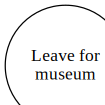

In [3]:
stn = nx.DiGraph()
stn.add_node('Leave for\nmuseum')
display_stn(stn)


Events can represent any specific point in time. A plan is made of many events. Going back to making pasta, the chef might want to include events for "Put pasta in water", "Take pot off boiler", "Strain pasta", "Pour sauce over pasta", and so on. Let's write out all of these events.

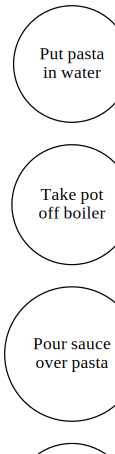

In [4]:
stn = nx.DiGraph()
stn.add_node('Put pasta\nin water')
stn.add_node('Take pot\noff boiler')
stn.add_node('Strain pasta')
stn.add_node('Pour sauce\nover pasta')
display_stn(stn)

So far, we just have a list of events without any sense of order or relation between them. The next step in writing a temporal network is identifying those relationships. We often call these "constraints" in that they constrain when events can happen relative to one another. For a Simple Temporal Network, constraints are represented as lower and upper bounds. For instance, if you could wait between 1 and 3 minutes after the straining the pasta to put the sauce on, you would have the following relationship:

$$\text{Strain pasta}\xrightarrow{[1,3]}\text{Pour sauce over pasta}$$

The arrow tells you the ordering of events. The `[1, 3]` notation represents a range between 1 and 3 inclusive. This means that, as the chef, you can _choose_ to wait anywhere between 1 and 3 minutes after straining to pour the sauce on. ;; FOOTNOTE ^[1] It is important to note that this representation means that you, the agent executing this temporal network, can choose where in the range the "Pour sauce over pasta" event takes place. Later, we will distinguish between the notion of choice that we have here, and the notion of uncertainty, which will manifest itself as "I don't know when in this range the event will happen."

You can use inequalities to mathematically describe the two events.

$$
1 \leq \text{Pour sauce over pasta} - \text{Strain pasta} \leq 3
$$

This inequality says that the time difference between pouring pasta and straining pasta must be between 1 and 3 minutes. You might be wondering why we changed the order of "Strain pasta" and "Pour sauce over pasta". In this inequality, we need to think about the time when events occur. Remember that pouring happens later. By this relationship, if we strained at 8:00pm, pouring would occur between 8:01 and 8:03pm. If you replace these times in the inequality, you'll find something like 8:03-8:01pm = 2 minutes, and $1 \leq 2 \leq 3$, which satisfies the constraint.

Thinking with inequalities will come in handy later.

Let's model a simplified plan for making pasta.

> It takes your stove 8 minutes to boil a pot of water. You can choose how long the pasta should boil in order to change its firmness. You can strain the pasta after 7 minutes if you like it firm, or you could wait 2 more minutes (9 total) if you want it softer. Once the pasta has been strained, you must pour the sauce over it within the next 5 minutes.

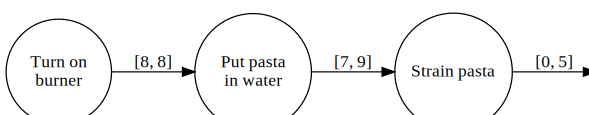

In [5]:
stn = nx.DiGraph()
stn.add_edge('Turn on\nburner', 'Put pasta\nin water', stc=[8, 8])
stn.add_edge('Put pasta\nin water', 'Strain pasta', stc=[7, 9])
stn.add_edge('Strain pasta', 'Pour sauce\nover pasta', stc=[0, 5])
display_stn(stn)

With the constraints filled in, we now have a [Simple Temporal Network](http://rakaposhi.eas.asu.edu/cse574/tcn-meiri-dechter-aij.pdf) (STN), also known as a Temporal Constraint Network. It includes the activities to perform and the relationships among activities. We have specified the events that have to happen and we have identified the relationships between those events.

Let's look at one type of relationship that you'll often see in STNs.

### Slack Constraints

What if all we care about is that one event happens after another? Think about the relationship between eating dinner and cleaning the dishes. You cannot clean the dishes until you have finished eating. In an STN, you can most simply represent this relationship using $[0, \infty]$ bounds, $\text{Eat dinner} \xrightarrow{[0, \infty]} \text{Clean dishes}$.

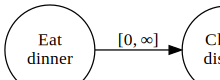

In [6]:
stn = nx.DiGraph()
stn.add_edge('Eat\ndinner', 'Clean\ndishes', stc=[0, np.inf])
# Shows the STN
display_stn(stn)

This is slack. All that the relationship $[0, \infty]$ tells us is the ordering of events. It allows any amount of time to elapse between them. (Of course, in practice, you should clean your dishes as soon as possible after dinner before food starts to stick to them :P)

And that's all there is to it for describing STNs! You know everything you need to start modeling plans in STNs.

# Modeling Temporal Constraints

To better grasp the math and sematics of temporal networks, let's investigate representing them with Python.

The code cell below installs some of the dependencies for this lesson. We'll be using `networkx` to represent graphs. While we'll include a short demo of its capabilities, if you'd like knowledge of some more advanced systems, check out [the documentation](https://networkx.org/documentation/stable/index.html). We'll also be using `numpy`, `matplotlib`, and some custom utilities to make visualizing STNs and distance graphs easier.

Imagine we have two events, A and B. These events are the _nodes_ in our STN.

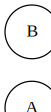

In [7]:
stn = nx.DiGraph()
stn.add_node('A')
stn.add_node('B')
# Shows the STN
display_stn(stn)

Let's add a _temporal constraint_ to our STN. This takes the form of a _directed edge_ in our network. If event B must occur no fewer than 2 minutes after A occurs, but it also has to happen within 4 minutes of A occuring. In an STN, these bounds are represented by a lower bound and upper bound for event execution $[l, u]$. This equates to $A \xrightarrow{[l, u]} B$ or $l \leq B - A \leq u$, where $B-A$ is the _temporal distance_ between the executions of events A and B.

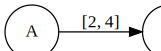

In [8]:
stn.add_edge('A', 'B', stc=[2, 4])
display_stn(stn)

Great! Now we've figured out how to represent the temporal constraint between two events. What if we want to represent the duration of a single activity consisting of a start event and an end event? Imagine that activity A takes between 3 and 5 minutes to complete. We can model this by separating activity A into two events: $A^-$, which denotes the _start_ of activity $A$, and $A^+$, which denotes the _end_ of the activity. Let's model this in our STN.

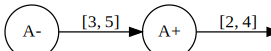

In [9]:
duration_stn = nx.DiGraph()
# Event A duration constraint
duration_stn.add_edge('A-', 'A+', stc=[3, 5])
duration_stn.add_edge('A+', 'B', stc=[2, 4])

display_stn(duration_stn)

And there you have it! STNs are surprisingly expressive; they can encode all sorts of interesting constraints between events.

### Parallel Sequences of Events

The power of STNs comes in being able to describe arbitrary temporal constraints. We have only encountered events in series so far, but we can easily use the mechanics of STNs to encode parallel activities. For instance, imagine your morning routine. You may want to listen to the news after you start getting dressed. Afterwards, you head downstairs to eat breakfast. We can show that with an STN.

Let's let $W$ represent waking up, $D$ represent getting dressed, $N$ represent listening to the news, and $B$ represent breakfast.

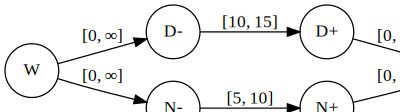

In [10]:
morning_stn = nx.DiGraph()

morning_stn.add_edge('W', 'D-', stc=[0, np.inf])
morning_stn.add_edge('W', 'N-', stc=[0, np.inf])
morning_stn.add_edge('D-', 'D+', stc=[10, 15])
morning_stn.add_edge('N-', 'N+', stc=[5, 10])
morning_stn.add_edge('D+', 'B-', stc=[0, np.inf])
morning_stn.add_edge('N+', 'B-', stc=[0, np.inf])

display_stn(morning_stn)

Note that the parallel constraints of $\text{D-} \xrightarrow{[10, 15]} \text{D+}$ and $\text{N-} \xrightarrow{[5, 10]} \text{N+}$ don't match up. So how is this a feasible STN? Each side of the parallel constraints are slack. This gives us flexibility in scheduling the $D$ and $N$ activities, which still indicating that they can occur in parallel.

### Problem 1

Let's put what we know together to encode a word problem that represents a more complex scenario.

> Peter is going to be late for school! It's 7:00AM, but school starts at 8:00, and he needs to shower (which takes between 5 and 10 minutes, depending on whether or not he wants to wash his hair), eat breakfast (which takes between 15 and 20 minutes), and travel to school (which takes exactly 45 minutes). Peter takes the bus to school, so he's able to multitask: he can travel and choose to spend between 10 and 20 minutes studying for his chemistry exam.

Before you scroll down to look at our STN, take a second to try writing one out yourself!

### Solution 1

There are multiple ways to represent this scenario. If your STN doesn't look exactly like ours, don't fret! Check the rubric below to see if you got the main points.

Let's let $S$ represent showering, $B$, represent breakfast, $T$ represent traveling, and $SC$ represent studying chemistry.

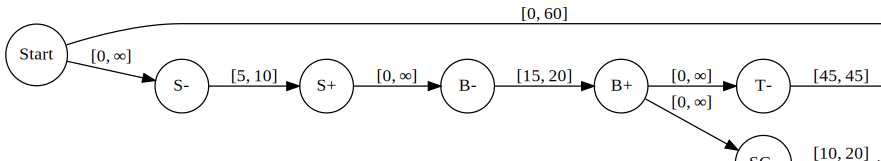

In [11]:
peter_stn = nx.DiGraph()

peter_stn.add_edge('Start', 'End', stc=[0, 60])
peter_stn.add_edge('Start', 'S-', stc=[0, np.inf])
peter_stn.add_edge('S-', 'S+', stc=[5, 10])
peter_stn.add_edge('S+', 'B-', stc=[0, np.inf])
peter_stn.add_edge('B-', 'B+', stc=[15, 20])
peter_stn.add_edge('B+', 'T-', stc=[0, np.inf])
peter_stn.add_edge('B+', 'SC-', stc=[0, np.inf])
peter_stn.add_edge('T-', 'T+', stc=[45, 45])
peter_stn.add_edge('T+', 'End', stc=[0, np.inf])
peter_stn.add_edge('SC-', 'SC+', stc=[10, 20])
peter_stn.add_edge('SC+', 'End', stc=[0, np.inf])

display_stn(peter_stn)

#### Rubric

- Must have start and end nodes
- Start and end nodes must be connected with $[0, 60]$
- All non-slack bounds must match the STN above
- Studying chemistry and traveling must be in parallel and branch from the end of breakfast
- There must be slack around studying chemistry and traveling

### Problem 2

Let's try another scenario!

> After school, Peter is so hungry that he needs to make dinner in 45 minutes. He has the ingredients for spaghetti and meatballs, and he decides to carboload after a long day of fighting crime and doing chemistry. He realizes that he can multitask, making the spaghetti and meatballs simultaneously. In order to make spaghetti, Peter must boil water (which will be done in 6 minutes and he doesn't want to wait more than 8 minutes to keep his energy bill down) and then cook the spaghetti (which takes between 10 and 12 minutes depending on desired firmness). In order to make the meatballs, Peter must preheat the oven (the oven will be ready in 7 minutes and he doesn't want to wait more than 9 to keep his energy bills down), mix the ingredients (1-2 minutes) and then cook the meatballs (20-24 minutes depending on how well done he wants the meatballs to be). Peter doesn't want cold spaghetti and meataballs, so the spaghetti and meatballs must be ready no more than 3 minutes before Peter starts plating. Once the spaghetti and meatballs are done, Peter can plate the dish (which takes between 1 and 2 minutes depending on how nice he wants to make the plate look). Finally, Peter must wait for the spaghetti to cool for no fewer than 3 minutes but no more than 5.

Before you scroll down to our solution, try to write it yourself! You may find you need a mix of slack, events by themselves, and activities broken into +/- events to describe this problem.

Let $BW$ be boiling the water and $CS$ be cooking the spaghetti. Let $PO$ be preheating the oven, $MI$ be mixing the ingredents, and $CM$ be cooking the meatballs. Let $P$ be plating.

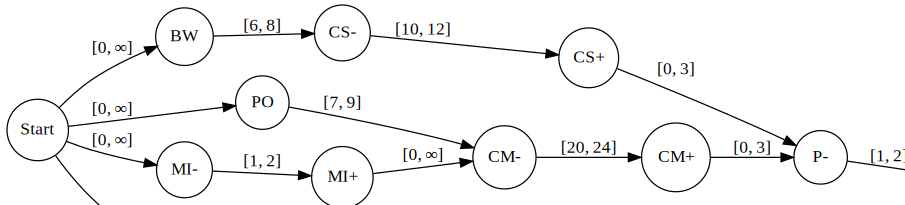

In [15]:
dinner_stn = nx.DiGraph()

dinner_stn.add_edge('Start', 'BW', stc=[0, np.inf]) 
dinner_stn.add_edge('BW', 'CS-', stc=[6, 8]) # Boiling water between 6 and 8 minutes
dinner_stn.add_edge('CS-', 'CS+', stc=[10,12]) # Cooking spaghetti between 10 and 12 minutes

dinner_stn.add_edge('Start', 'PO', stc=[0, np.inf]) 
dinner_stn.add_edge('Start', 'MI-', stc=[0, np.inf]) 
dinner_stn.add_edge('PO', 'CM-', stc=[7, 9]) # Preheating the oven between 7 and 9 minutes
dinner_stn.add_edge('MI-', 'MI+', stc=[1, 2]) # Mixing the ingredients between 1 and 2 minutes
dinner_stn.add_edge('MI+', 'CM-', stc=[0, np.inf]) # Must mix ingredients before cooking
dinner_stn.add_edge('CM-', 'CM+', stc=[20, 24]) # Cooking the meatballs between 20 and 24 minutes

dinner_stn.add_edge('CS+', 'P-', stc=[0, 3]) # No cold spaghetti
dinner_stn.add_edge('CM+', 'P-', stc=[0, 3]) # No cold meatballs
dinner_stn.add_edge('P-', 'P+', stc=[1, 2]) # Plating between 1 and 2 minutes
dinner_stn.add_edge('P+', 'End', stc=[3, 5]) # Peter wants his spaghetti and meatballs to be a good temperature

dinner_stn.add_edge('Start', 'End', stc=[0, 45]) # Dinner must be ready in 45 minutes

display_stn(dinner_stn)

#### Rubric

Once again, your STN might look slightly different than ours. Here are a few key points.

- Must have start and end nodes
- Start and end must be connected by $[0, 45]$
- There must be slack around preheating the oven and mixing ingredients
- There must be slack around boiling water and cooking spaghetti
- The meatballs and spaghetti must be done before plating